In [ ]:
import sqlite3
import pandas as pd
import random
from faker import Faker

#Initialize Faker to generate fake names, locations, and timestamps
fake = Faker("id_ID")

#Number of Records of data to fake
num_users = 100
num_robots = 150
num_commands = 10000

#Fake device models with predefined attributes (battery life, response speed, error rate)
device_models = {
    "MikoVexa Basic": {"battery_range": (10, 12), "response_range": (1.5, 3.0), "error_chance": 0.2},
    "MikoVexa Pro": {"battery_range": (12, 14), "response_range": (1.0, 2.5), "error_chance": 0.1}
}
#AI states
ai_modes = ["Aktif", "Siaga", "Mendengarkan", "Menjalankan Perintah", "Mengisi Daya"]
error_messages = ["Baterai Lemah", "Kesalahan Navigasi", "Gangguan Mikrofon", "Kamera Tidak Merespons"]

#Security events
security_logs_options = [
    "Percobaan login gagal", "Firmware diperbarui", "Mode keamanan diaktifkan",
    "Peringatan akses tidak sah", "Perangkat diakses dari lokasi baru"
]

#Predifined fake command templates for each room type
room_commands = {
    "Ruang Tamu": ["Putar musik jazz", "Nyalakan lampu ruang tamu", "Atur suhu AC ke 24 derajat"],
    "Dapur": ["Hidupkan blender pintar", "Matikan oven", "Set timer untuk 10 menit"],
    "Garasi": ["Mode parkir otomatis", "Cek status baterai", "Aktifkan mode keamanan"],
    "Kantor": ["Jadwalkan rapat besok", "Atur suhu ruangan ke 22 derajat", "Tampilkan notifikasi email"],
    "Kamar Tidur": ["Atur alarm pukul 06:00", "Nyalakan lampu tidur", "Putar suara hujan"]
}
rooms = list(room_commands.keys())

#Generate Fake Users Table with unique IDs, names, locations 
users = [(i, fake.name().replace("'", "''"), fake.city().replace("'", "''")) for i in range(1, num_users + 1)]
df_users = pd.DataFrame(users, columns=["user_id", "name", "location"])

#Generate fake robots with different models, battery levels, and other stuff
robots = []
for i in range(1, num_robots + 1):
    user_id = random.randint(1, num_users)
    device_model = random.choice(list(device_models.keys()))
    model_specs = device_models[device_model]
    battery_level = random.randint(*model_specs["battery_range"])
    ai_mode = random.choice(ai_modes)
    last_charge = fake.date_time_this_month().strftime("%Y-%m-%d %H:%M:%S")
    device_status = random.choice(["Aktif", "Siaga", "Mengisi Daya"])
    robots.append((i, user_id, device_model, battery_level, ai_mode, last_charge, device_status))

df_robots = pd.DataFrame(robots, columns=["robot_id", "user_id", "device_model", "battery_level", "ai_mode", "last_charge", "device_status"])

#Generate a set of fake commands issued to robots, with response time, errors, and confidence levels
commands = []
for i in range(1, num_commands + 1):
    user_id = random.randint(1, num_users)
    robot_id = random.randint(1, num_robots)
    location_room = random.choice(rooms)
    command_text = random.choice(room_commands[location_room])

    #Identify the robot's model
    model_specs = next(d for d in robots if d[0] == robot_id)[2]  
    response_time = round(random.uniform(*device_models[model_specs]["response_range"]), 2)
    error_logs = "Tidak Ada Kesalahan" if random.random() > device_models[model_specs]["error_chance"] else random.choice(error_messages)

    #Categorize command intent
    intent_category = "Rumah Pintar" if "lampu" in command_text or "AC" in command_text else \
                      "Pengingat" if "Jadwalkan" in command_text or "Set timer" in command_text else \
                      "Keamanan" if "keamanan" in command_text else \
                      "Hiburan" if "musik" in command_text or "video" in command_text else \
                      "Produktivitas"

    timestamp = fake.date_time_this_year()
    session_id = random.randint(1000, 9999)
    voice_confidence = round(random.uniform(0.6 if model_specs == "MikoVexa Basic" else 0.8, 1.0), 2)
    usage_frequency = random.randint(1, 30)

    commands.append((i, user_id, robot_id, command_text, response_time, error_logs, timestamp, intent_category, session_id, location_room, voice_confidence, usage_frequency))

df_commands = pd.DataFrame(commands, columns=["command_id", "user_id", "robot_id", "command_text", "response_time", "error_logs", "timestamp", "intent_category", "session_id", "location_room", "voice_confidence", "usage_frequency"])

#Generate security-related logs such as failed login attempts and unauthorized access
security_logs = [(i, random.randint(1, num_users), random.randint(1, num_robots), random.choice(security_logs_options), fake.date_time_this_year()) for i in range(1, num_commands // 10)]
df_security_logs = pd.DataFrame(security_logs, columns=["log_id", "user_id", "robot_id", "log_message", "timestamp"])

#Save as CSV
df_users.to_csv("mikovexa_users.csv", index=False)
df_robots.to_csv("mikovexa_robots.csv", index=False)
df_commands.to_csv("mikovexa_commands.csv", index=False)
df_security_logs.to_csv("mikovexa_security_logs.csv", index=False)

print("Saved as CSV")

#Save as SQL
with open("mikovexa_synthetic_data.sql", "w") as f:
    f.write("CREATE TABLE users (user_id INT PRIMARY KEY, name TEXT, location TEXT);\n")
    for _, row in df_users.iterrows():
        f.write(f"INSERT INTO users VALUES ({row['user_id']}, '{row['name']}', '{row['location']}');\n")

    f.write("\nCREATE TABLE mikovexa_robots (robot_id INT PRIMARY KEY, user_id INT, device_model TEXT, battery_level INT, ai_mode TEXT, last_charge TEXT, FOREIGN KEY (user_id) REFERENCES users(user_id));\n")
    for _, row in df_robots.iterrows():
        f.write(f"INSERT INTO mikovexa_robots VALUES ({row['robot_id']}, {row['user_id']}, '{row['device_model']}', {row['battery_level']}, '{row['ai_mode']}', '{row['last_charge']}');\n")

print("Saved as SQL")

#Save as SQLite (.db)
conn = sqlite3.connect("mikovexa_synthetic_data.db")
df_users.to_sql("users", conn, if_exists="replace", index=False)
df_robots.to_sql("mikovexa_robots", conn, if_exists="replace", index=False)
df_commands.to_sql("commands", conn, if_exists="replace", index=False)
df_security_logs.to_sql("security_logs", conn, if_exists="replace", index=False)
conn.close()

print("Saved in SQLite (.db)")

Saved as CSV
Saved as SQL
Saved in SQLite (.db)


In [22]:
import pandas as pd
import sqlite3
from docx import Document

#Creating tables in CSV and docx to put the synthetic SQL in document easily
#Connect to the SQLite database
conn = sqlite3.connect("mikovexa_synthetic_data.db")
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = [table[0] for table in cursor.fetchall()]

#Initialize a word doc
doc = Document()
doc.add_heading("MikoVexa SQL Tables", level=1)

#Export each table as CSV and add to Word
for table_name in tables:
    df = pd.read_sql_query(f"SELECT * FROM {table_name} LIMIT 10", conn)
    csv_filename = f"{table_name}.csv"
    df.to_csv(csv_filename, index=False, encoding="utf-8")
    print(f"Saved {csv_filename}")
    doc.add_heading(f"{table_name} Table", level=2)
    table = doc.add_table(rows=df.shape[0] + 1, cols=df.shape[1])

    #Add headers
    for j, col_name in enumerate(df.columns):
        table.cell(0, j).text = col_name

    #Add rows
    for i, row in df.iterrows():
        for j, value in enumerate(row):
            table.cell(i + 1, j).text = str(value)

#Save the Word document
word_filename = "MikoVexa_SQL_Tables.docx"
doc.save(word_filename)
print(f"Saved {word_filename}")

#Close connection
conn.close()

Saved users.csv
Saved mikovexa_robots.csv
Saved commands.csv
Saved security_logs.csv
Saved MikoVexa_SQL_Tables.docx


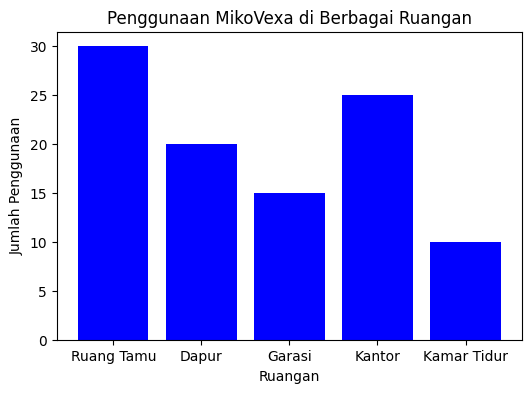

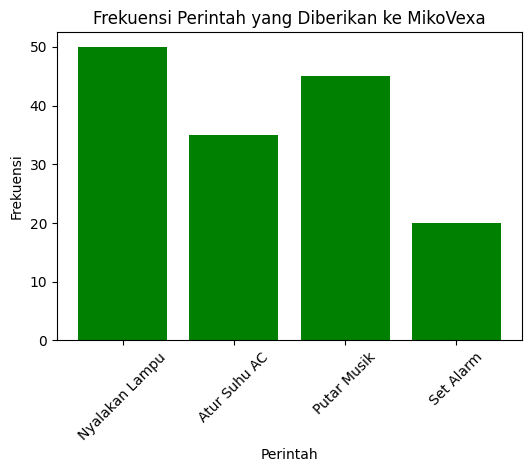

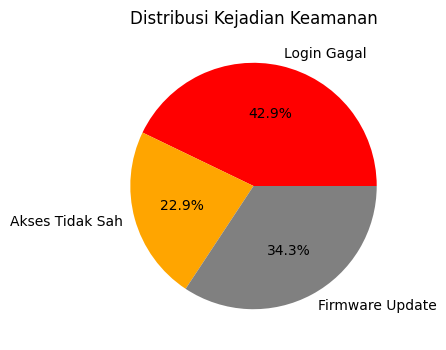

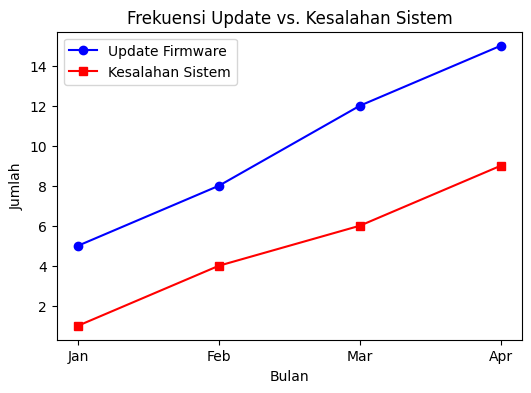

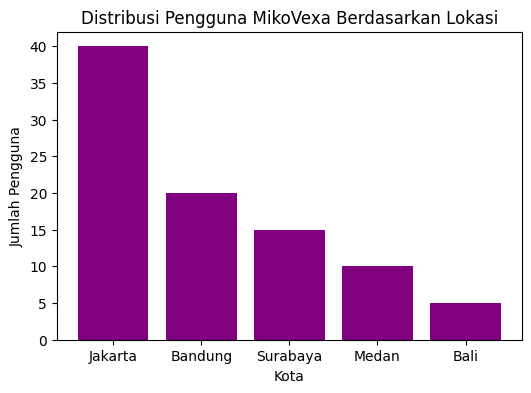

In [23]:
#Graphs for the user manual
import matplotlib.pyplot as plt

#Device Usage by Room
device_usage = {"Ruang Tamu": 30, "Dapur": 20, "Garasi": 15, "Kantor": 25, "Kamar Tidur": 10}
plt.figure(figsize=(6,4))
plt.bar(device_usage.keys(), device_usage.values(), color="blue")
plt.xlabel("Ruangan")
plt.ylabel("Jumlah Penggunaan")
plt.title("Penggunaan MikoVexa di Berbagai Ruangan")
plt.savefig("device_usage_chart.png")

#Most Frequently Used Commands
commands_frequency = {"Nyalakan Lampu": 50, "Atur Suhu AC": 35, "Putar Musik": 45, "Set Alarm": 20}
plt.figure(figsize=(6,4))
plt.bar(commands_frequency.keys(), commands_frequency.values(), color="green")
plt.xlabel("Perintah")
plt.ylabel("Frekuensi")
plt.title("Frekuensi Perintah yang Diberikan ke MikoVexa")
plt.xticks(rotation=45)
plt.savefig("commands_frequency_chart.png")

#Security Incidents
security_events = {"Login Gagal": 15, "Akses Tidak Sah": 8, "Firmware Update": 12}
plt.figure(figsize=(6,4))
plt.pie(security_events.values(), labels=security_events.keys(), autopct="%1.1f%%", colors=["red", "orange", "gray"])
plt.title("Distribusi Kejadian Keamanan")
plt.savefig("security_events_chart.png")

#Software Update & Error Logs
updates_vs_errors = {"Update Firmware": [5, 8, 12, 15], "Kesalahan Sistem": [1, 4, 6, 9]}
months = ["Jan", "Feb", "Mar", "Apr"]
plt.figure(figsize=(6,4))
plt.plot(months, updates_vs_errors["Update Firmware"], marker="o", label="Update Firmware", color="blue")
plt.plot(months, updates_vs_errors["Kesalahan Sistem"], marker="s", label="Kesalahan Sistem", color="red")
plt.xlabel("Bulan")
plt.ylabel("Jumlah")
plt.title("Frekuensi Update vs. Kesalahan Sistem")
plt.legend()
plt.savefig("software_updates_chart.png")

#User Demographics & Locations
user_locations = {"Jakarta": 40, "Bandung": 20, "Surabaya": 15, "Medan": 10, "Bali": 5}
plt.figure(figsize=(6,4))
plt.bar(user_locations.keys(), user_locations.values(), color="purple")
plt.xlabel("Kota")
plt.ylabel("Jumlah Pengguna")
plt.title("Distribusi Pengguna MikoVexa Berdasarkan Lokasi")
plt.savefig("user_locations_chart.png")